In [69]:
import glob

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

import conv_mod

In [70]:
im_size = 128
latent_size = 512
batch_size = 8
cha = 24 #Should be 32
n_layers = int(np.log2(im_size) - 2) # 5 for 128 
mixed_prob = 0.9
channels_mult_list = [1,2,4,6,8,12,16,32,48,64]

In [71]:
def latent_z(n):
    # Z 
    return np.random.normal(0.0, 1.0, size = [n, latent_size]).astype('float32')

def latent_z_list(n):
    return [latent_z(n)] * n_layers

def mixed_latent_z(n):
    tt = int(np.random.random() * n_layers)
    p1 = [latent_z(n)] * tt
    p2 = [latent_z(n)] * (n_layers - tt)
    return p1 + p2 #list concatenation

def noise_image(batch_size):
    return np.random.uniform(0.0, 1.0, size = [batch_size, im_size, im_size, 1]).astype('float32')

#Loss functions
def gradient_penalty(samples, output, weight):
    gradients = K.gradients(output, samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * weight

def crop_to_fit(x):
    height = x[1].shape[1]
    width = x[1].shape[2]
    return x[0][:, :height, :width, :]

def upsample(x):
    return K.resize_images(x,2,2,"channels_last",interpolation='bilinear')

def upsample_to_size(x):
    y = im_size // x.shape[2]
    x = K.resize_images(x, y, y, "channels_last",interpolation='bilinear')
    return x

In [72]:
def g_block(x, input_style, input_noise, nb_filters, upsampling = True):
    input_filters = x.shape[-1]
    if upsampling:
        x = keras.layers.UpSampling2D(interpolation='bilinear')(x)
        
    
    rgb_style = keras.layers.Dense(nb_filters, kernel_initializer = keras.initializers.VarianceScaling(200/x.shape[2]))(input_style)
    style = keras.layers.Dense(input_filters, kernel_initializer = 'he_uniform')(input_style)
    
    noise_cropped = keras.layers.Lambda(crop_to_fit)([input_noise, x]) ########
    d = keras.layers.Dense(nb_filters, kernel_initializer='zeros')(noise_cropped)

    x = conv_mod.Conv2DMod(filters=nb_filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([x, style])
    x = keras.layers.add([x, d])
    x = keras.layers.LeakyReLU(0.2)(x)

    style = keras.layers.Dense(nb_filters, kernel_initializer = 'he_uniform')(input_style)
    d = keras.layers.Dense(nb_filters, kernel_initializer = 'zeros')(noise_cropped)

    x = conv_mod.Conv2DMod(filters = nb_filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([x, style])
    x = keras.layers.add([x, d])
    x = keras.layers.LeakyReLU(0.2)(x)

    return x, to_rgb(x, rgb_style)

def d_block(inp, fil, p = True):

    res = keras.layers.Conv2D(fil, 1, kernel_initializer = 'he_uniform')(inp)

    out = keras.layers.Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(inp)
    out = keras.layers.LeakyReLU(0.2)(out)
    out = keras.layers.Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(out)
    out = keras.layers.LeakyReLU(0.2)(out)

    out = keras.layers.add([res, out])

    if p:
        out = keras.layers.AveragePooling2D()(out)

    return out

def to_rgb(inp, style):
    size = inp.shape[2]
    x = conv_mod.Conv2DMod(3, 1, kernel_initializer = keras.initializers.VarianceScaling(200/size), 
                              demod = False)([inp, style])
    return keras.layers.Lambda(upsample_to_size, output_shape=[None, im_size, im_size, None])(x)

def from_rgb(inp, conc = None):
    fil = int(im_size * 4 / inp.shape[2])
    z = keras.layers.AveragePooling2D()(inp)
    x = keras.layers.Conv2D(fil, 1, kernel_initializer = 'he_uniform')(z)
    if conc is not None:
        x = keras.layers.concatenate([x, conc])
    return x, z

In [112]:
class StyleGan(keras.Model):
    def __init__(self, steps = 0, lr = 0.0001, decay = 0.00001):
        super(StyleGan, self).__init__()
        
        #Models
        self.D = self.make_discriminator()
        self.S = self.make_style_map()
        self.G = self.make_generator()
        
        #Config
        self.LR = lr
        self.steps = steps
        self.beta = 0.999

        self.G_opt = keras.optimizers.Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        self.D_opt = keras.optimizers.Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        
        self.pl_mean = 0
        self.av = np.zeros([44])
        
    def make_discriminator(self):
        d_input = keras.layers.Input(shape = [im_size, im_size, 3])
        x = d_input
        
        nb_d_layers = int(np.log2(im_size))
        
        channels_mult = 1
        nb_D_layer = int(np.log2(im_size))
        for channels_mult in channels_mult_list[:nb_D_layer-1]:
            x = d_block(x, channels_mult * cha)
            channels_mult*=2
        x = d_block(x, channels_mult_list[nb_D_layer-1] * cha, p = False)
        print("shape before flatten in D", x.shape)
        
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1, kernel_initializer = 'he_uniform')(x)
        return keras.models.Model(inputs = d_input, outputs = x)

    def make_style_map(self):
        S = keras.models.Sequential()
        S.add(keras.layers.Dense(512, input_shape = [latent_size]))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        return S
    
    def make_generator(self):
        inp_style = keras.layers.Input([n_layers, 512])
        inp_noise = keras.layers.Input([im_size, im_size, 1])
    
        #Latent
        x = inp_style[:,0,:1] * 0 + 1

        outs = []

        start_dim = im_size // (2**n_layers)
        x = keras.layers.Dense(4*4*4*cha, activation = 'relu', use_bias=False, 
                              kernel_initializer = 'random_normal')(x)
        x = keras.layers.Reshape([start_dim, start_dim, start_dim*cha])(x)

        
        for i, channels_mult in enumerate(channels_mult_list[:n_layers][::-1]):
            x, r = g_block(x, inp_style[:,i], inp_noise, channels_mult * cha, upsampling = (i!=0))  
            outs.append(r)

        x = keras.layers.add(outs)
        x = keras.layers.Lambda(lambda y: y/2 + 0.5)(x) #Use values centered around 0, but normalize to [0, 1], providing better initialization

        return keras.models.Model(inputs = [inp_style, inp_noise], outputs = x)

    @tf.function
    def tf_train_step(self, images, style1, style2, style2_idx, noise, perform_gp=True, perform_pl=False):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #Get style information
            w_1 = self.S(style1)
            w_2 = self.S(style2)
            w_space = tf.repeat(tf.stack([w_1,w_2], axis=1),[style2_idx, n_layers-style2_idx],axis=1)
            pl_lengths = self.pl_mean

            #Generate images
            generated_images = self.G([w_space,noise], training=True)

            #Discriminate
            real_output = self.D(images, training=True)
            fake_output = self.D(generated_images, training=True)

            #Hinge loss function
            gen_loss = K.mean(fake_output)
            divergence = K.mean(K.relu(1 + real_output) + K.relu(1 - fake_output))
            disc_loss = divergence

            if perform_gp:
                #R1 gradient penalty
                disc_loss += gradient_penalty(images, real_output, 10)

            if perform_pl:
                #Slightly adjust W space
                w_space_2 = []
                for i in range(n_layers):
                    w_slice = w_space[:,i]
                    std = 0.1 / (K.std(w_slice, axis = 0, keepdims = True) + 1e-8)
                    w_space_2.append(w_slice + K.random_normal(tf.shape(w_slice)) / (std + 1e-8))
                w_space_2 = tf.stack(w_space_2, axis=1)
                print(w_space_2.shape, w_space.shape)
                #Generate from slightly adjusted W space
                pl_images = self.G([w_space_2,noise], training=True)

                #Get distance after adjustment (path length)
                delta_g = K.mean(K.square(pl_images - generated_images), axis = [1, 2, 3])
                pl_lengths = delta_g

                if self.pl_mean > 0:
                    gen_loss += K.mean(K.square(pl_lengths - self.pl_mean))

        #Get gradients for respective areas
        gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables + self.S.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)

        #Apply gradients
        self.G_opt.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables + self.S.trainable_variables))
        self.D_opt.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

        return disc_loss, gen_loss, divergence, pl_lengths

    def train_step(self, args):
        images, style1, style2, style2_idx, noise = args
        self.steps += 1
        
        apply_gradient_penalty = self.steps % 2 == 0 or self.steps < 10000
        apply_path_penalty = self.steps % 16 == 0
        
        disc_loss, gen_loss, divergence, pl_lengths = self.tf_train_step(images, style1, style2, 
                                                                         style2_idx, noise, 
                                                                         apply_gradient_penalty, 
                                                                         apply_path_penalty)
        
        if self.pl_mean == 0:
            self.pl_mean = np.mean(pl_lengths)
        self.pl_mean = 0.99*self.pl_mean + 0.01*np.mean(pl_lengths)

        if np.isnan(disc_loss):
            print("NaN Value Error.")
            raise ValueError('Nan in loss')
            
        return {
            "disc_loss":disc_loss,
            "gen_loss":gen_loss,
            "divergence":divergence,
            "pl_lengths":pl_lengths,
        }
            

In [113]:
dataset = train_dataset().take(51000//batch_size)
model = StyleGan()
model.compile(run_eagerly=Tru e)
model.fit(dataset)

Number of train images found: 52597
shape before flatten in D (None, 2, 2, 384)
     15/Unknown - 2s 143ms/step - disc_loss: 25.0580 - gen_loss: 3.7070 - divergence: 21.3070 - pl_lengths: 0.0000e+00(8, 5, 512) (8, 5, 512)
6250/6250 [==============================] - 973s 156ms/step - disc_loss: 1.2351 - gen_loss: 1.1930 - divergence: 0.9514 - pl_lengths: 0.0147


Number of train images found: 52597
6574/6574 [==============================] - 986s 150ms/step - disc_loss: 1.4104 - gen_loss: 0.5459 - divergence: 1.1917 - pl_lengths: 0.0457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


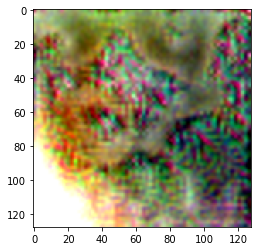

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


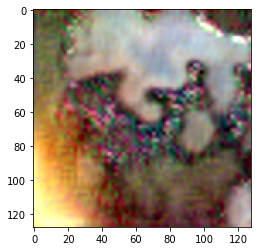

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


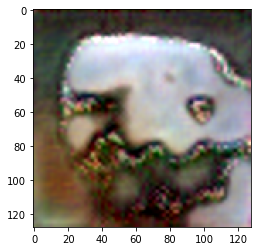

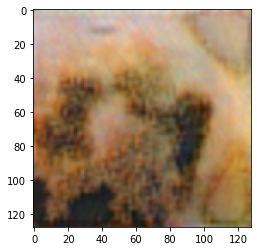

Number of train images found: 52597
   3012/Unknown - 422s 140ms/step - disc_loss: 1.2632 - gen_loss: 0.6481 - divergence: 1.0227 - pl_lengths: 0.0662

In [ ]:
for i in range(20):
    dataset = train_dataset().take(52597//batch_size)
    model.fit(dataset)
    noise = noise_image(batch_size)
    l_z = latent_z(batch_size)
    l_w = model.S(l_z)
    style = tf.stack([l_w for i in range(n_layers)],axis=1)
    generated= model.G([style,noise])
    plt.imshow(generated[0])
    plt.show()
    plt.imshow(generated[1])
    plt.show()
    plt.imshow(generated[2])
    plt.show()
    plt.imshow(generated[3])
    plt.show()
    

In [41]:
def read_image(im_path):
    im_file = tf.io.read_file(im_path)
    im = tf.io.decode_jpeg(im_file, channels=3)
    im = tf.image.resize(im, (im_size,im_size))
    im = tf.image.random_flip_left_right(im)
    im = tf.image.convert_image_dtype(im, tf.float32)/255
    return im

def train_dataset():
    path = "/Data/leo/dogs-face-2015/*.jpg"
    im_dataset = tf.data.Dataset.list_files(path)
    im_dataset = im_dataset.map(read_image)
    im_dataset = im_dataset.repeat()
    im_dataset = im_dataset.batch(batch_size)
    
    nb_train_image = len(glob.glob(path))
    print("Number of train images found:", nb_train_image)
    
    def gen_latent_z():
        while 1:
            yield latent_z(batch_size)
 
    def gen_noise():
        while 1:
            yield noise_image(batch_size)
            
    def gen_mixed_idx():
        while 1:
            if np.random.random() < mixed_prob:
                yield np.random.randint(n_layers)
            else:
                yield n_layers
                       
    latent_z1_dataset = tf.data.Dataset.from_generator(gen_latent_z, (tf.float32))
    latent_z2_dataset = tf.data.Dataset.from_generator(gen_latent_z, (tf.float32))
    noise_dataset = tf.data.Dataset.from_generator(gen_noise, (tf.float32))
    mixed_idx_dataset = tf.data.Dataset.from_generator(gen_mixed_idx, (tf.int32))
    
    dataset = tf.data.Dataset.zip((im_dataset, latent_z1_dataset, latent_z2_dataset, 
                                   mixed_idx_dataset, noise_dataset))
    dataset = dataset.prefetch(1)
    return dataset

In [17]:
import matplotlib.pyplot as plt

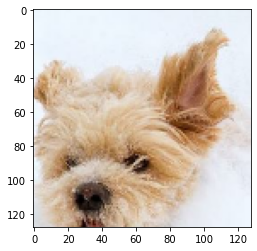

In [19]:
plt.imshow(images[1])

In [43]:
class GAN(keras.Model):
    def __init__(self, steps = 1, lr = 0.0001, decay = 0.00001):
        super(Conv2DMod, self).__init__(**kwargs)
        
        #Models
        self.D = None
        self.S = None
        self.G = None

        self.GE = None
        self.SE = None

        self.DM = None
        self.AM = None

        #Config
        self.LR = lr
        self.steps = steps
        self.beta = 0.999

        #Init Models
        self.discriminator()
        self.generator()

        self.GMO = Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        self.DMO = Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)

        self.GE = clone_model(self.G)
        self.GE.set_weights(self.G.get_weights())

        self.SE = clone_model(self.S)
        self.SE.set_weights(self.S.get_weights())

    def discriminator(self):

        if self.D:
            return self.D

        inp = Input(shape = [im_size, im_size, 3])


        x = d_block(inp, 1 * cha)   #128

        x = d_block(x, 2 * cha)   #64

        x = d_block(x, 4 * cha)   #32

        x = d_block(x, 6 * cha)  #16

        x = d_block(x, 8 * cha)  #8

        x = d_block(x, 16 * cha)  #4

        x = d_block(x, 32 * cha, p = False)  #4

        x = Flatten()(x)

        x = Dense(1, kernel_initializer = 'he_uniform')(x)

        self.D = Model(inputs = inp, outputs = x)

        return self.D

    def generator(self):

        if self.G:
            return self.G

        # === Style Mapping ===

        self.S = keras.models.Sequential()

        self.S.add(Dense(512, input_shape = [latent_size]))
        self.S.add(LeakyReLU(0.2))
        self.S.add(Dense(512))
        self.S.add(LeakyReLU(0.2))
        self.S.add(Dense(512))
        self.S.add(LeakyReLU(0.2))
        self.S.add(Dense(512))
        self.S.add(LeakyReLU(0.2))


        # === Generator ===

        #Inputs
        inp_style = []

        for i in range(n_layers):
            inp_style.append(Input([512]))

        inp_noise = Input([im_size, im_size, 1])

        #Latent
        x = Lambda(lambda x: x[:, :1] * 0 + 1)(inp_style[0])

        outs = []

        #Actual Model
        x = Dense(4*4*4*cha, activation = 'relu', kernel_initializer = 'random_normal')(x)
        x = Reshape([4, 4, 4*cha])(x)

        x, r = g_block(x, inp_style[0], inp_noise, 32 * cha, u = False)  #4
        outs.append(r)

        x, r = g_block(x, inp_style[1], inp_noise, 16 * cha)  #8
        outs.append(r)

        x, r = g_block(x, inp_style[2], inp_noise, 8 * cha)  #16
        outs.append(r)

        x, r = g_block(x, inp_style[3], inp_noise, 6 * cha)  #32
        outs.append(r)

        x, r = g_block(x, inp_style[4], inp_noise, 4 * cha)   #64
        outs.append(r)

        x, r = g_block(x, inp_style[5], inp_noise, 2 * cha)   #128
        outs.append(r)

        x, r = g_block(x, inp_style[6], inp_noise, 1 * cha)   #256
        outs.append(r)

        x = add(outs)

        x = Lambda(lambda y: y/2 + 0.5)(x) #Use values centered around 0, but normalize to [0, 1], providing better initialization

        self.G = Model(inputs = inp_style + [inp_noise], outputs = x)

        return self.G

    def GenModel(self):

        #Generator Model for Evaluation

        inp_style = []
        style = []

        for i in range(n_layers):
            inp_style.append(Input([latent_size]))
            style.append(self.S(inp_style[-1]))

        inp_noise = Input([im_size, im_size, 1])

        gf = self.G(style + [inp_noise])

        self.GM = Model(inputs = inp_style + [inp_noise], outputs = gf)

        return self.GM

    def GenModelA(self):

        #Parameter Averaged Generator Model

        inp_style = []
        style = []

        for i in range(n_layers):
            inp_style.append(Input([latent_size]))
            style.append(self.SE(inp_style[-1]))

        inp_noise = Input([im_size, im_size, 1])

        gf = self.GE(style + [inp_noise])

        self.GMA = Model(inputs = inp_style + [inp_noise], outputs = gf)

        return self.GMA

    def EMA(self):

        #Parameter Averaging

        for i in range(len(self.G.layers)):
            up_weight = self.G.layers[i].get_weights()
            old_weight = self.GE.layers[i].get_weights()
            new_weight = []
            for j in range(len(up_weight)):
                new_weight.append(old_weight[j] * self.beta + (1-self.beta) * up_weight[j])
            self.GE.layers[i].set_weights(new_weight)

        for i in range(len(self.S.layers)):
            up_weight = self.S.layers[i].get_weights()
            old_weight = self.SE.layers[i].get_weights()
            new_weight = []
            for j in range(len(up_weight)):
                new_weight.append(old_weight[j] * self.beta + (1-self.beta) * up_weight[j])
            self.SE.layers[i].set_weights(new_weight)

    def MAinit(self):
        #Reset Parameter Averaging
        self.GE.set_weights(self.G.get_weights())
        self.SE.set_weights(self.S.get_weights())






class StyleGAN(object):

    def __init__(self, steps = 1, lr = 0.0001, decay = 0.00001, silent = True):

        #Init GAN and Eval Models
        self.GAN = GAN(steps = steps, lr = lr, decay = decay)
        self.GAN.GenModel()
        self.GAN.GenModelA()

        self.GAN.G.summary()

        #Data generator (my own code, not from TF 2.0)
        self.im = dataGenerator(dataset, im_size, BATCH_SIZE, flip = True)

        #Set up variables
        self.lastblip = time.clock()

        self.silent = silent

        self.ones = np.ones((BATCH_SIZE, 1), dtype=np.float32)
        self.zeros = np.zeros((BATCH_SIZE, 1), dtype=np.float32)
        self.nones = -self.ones

        self.pl_mean = 0
        self.av = np.zeros([44])

    def train(self):

        #Train Alternating
        if random() < mixed_prob:
            style = mixedList(BATCH_SIZE)
        else:
            style = noiseList(BATCH_SIZE)

        #Apply penalties every 16 steps
        apply_gradient_penalty = self.GAN.steps % 2 == 0 or self.GAN.steps < 10000
        apply_path_penalty = self.GAN.steps % 16 == 0

        a, b, c, d = self.train_step(self.im.get_batch(), style, nImage(BATCH_SIZE), apply_gradient_penalty, apply_path_penalty)

        #Adjust path length penalty mean
        #d = pl_mean when no penalty is applied
        if self.pl_mean == 0:
            self.pl_mean = np.mean(d)
        self.pl_mean = 0.99*self.pl_mean + 0.01*np.mean(d)

        if self.GAN.steps % 10 == 0 and self.GAN.steps > 20000:
            self.GAN.EMA()

        if self.GAN.steps <= 25000 and self.GAN.steps % 1000 == 2:
            self.GAN.MAinit()

        if np.isnan(a):
            print("NaN Value Error.")
            exit()


        #Print info
        if self.GAN.steps % 100 == 0 and not self.silent:
            print("\n\nRound " + str(self.GAN.steps) + ":")
            print("D:", np.array(a))
            print("G:", np.array(b))
            print("PL:", self.pl_mean)

            s = round((time.clock() - self.lastblip), 4)
            self.lastblip = time.clock()

            steps_per_second = 100 / s
            steps_per_minute = steps_per_second * 60
            steps_per_hour = steps_per_minute * 60
            print("Steps/Second: " + str(round(steps_per_second, 2)))
            print("Steps/Hour: " + str(round(steps_per_hour)))

            min1k = floor(1000/steps_per_minute)
            sec1k = floor(1000/steps_per_second) % 60
            print("1k Steps: " + str(min1k) + ":" + str(sec1k))
            steps_left = 200000 - self.GAN.steps + 1e-7
            hours_left = steps_left // steps_per_hour
            minutes_left = (steps_left // steps_per_minute) % 60

            print("Til Completion: " + str(int(hours_left)) + "h" + str(int(minutes_left)) + "m")
            print()

            #Save Model
            if self.GAN.steps % 2000 == 0:
                self.save(floor(self.GAN.steps / 10000))
            if self.GAN.steps % 2000 == 0 or (self.GAN.steps % 500 == 0 and self.GAN.steps < 2500):
                self.evaluate(floor(self.GAN.steps / 2000))


        printProgressBar(self.GAN.steps % 100, 99, decimals = 0)

        self.GAN.steps = self.GAN.steps + 1

    @tf.function
    def train_step(self, images, style, noise, perform_gp = True, perform_pl = False):

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #Get style information
            w_space = []
            pl_lengths = self.pl_mean
            for i in range(len(style)):
                w_space.append(self.GAN.S(style[i]))

            #Generate images
            generated_images = self.GAN.G(w_space + [noise])

            #Discriminate
            real_output = self.GAN.D(images, training=True)
            fake_output = self.GAN.D(generated_images, training=True)

            #Hinge loss function
            gen_loss = K.mean(fake_output)
            divergence = K.mean(K.relu(1 + real_output) + K.relu(1 - fake_output))
            disc_loss = divergence

            if perform_gp:
                #R1 gradient penalty
                disc_loss += gradient_penalty(images, real_output, 10)

            if perform_pl:
                #Slightly adjust W space
                w_space_2 = []
                for i in range(len(style)):
                    std = 0.1 / (K.std(w_space[i], axis = 0, keepdims = True) + 1e-8)
                    w_space_2.append(w_space[i] + K.random_normal(tf.shape(w_space[i])) / (std + 1e-8))

                #Generate from slightly adjusted W space
                pl_images = self.GAN.G(w_space_2 + [noise])

                #Get distance after adjustment (path length)
                delta_g = K.mean(K.square(pl_images - generated_images), axis = [1, 2, 3])
                pl_lengths = delta_g

                if self.pl_mean > 0:
                    gen_loss += K.mean(K.square(pl_lengths - self.pl_mean))

        #Get gradients for respective areas
        gradients_of_generator = gen_tape.gradient(gen_loss, self.GAN.GM.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.GAN.D.trainable_variables)

        #Apply gradients
        self.GAN.GMO.apply_gradients(zip(gradients_of_generator, self.GAN.GM.trainable_variables))
        self.GAN.DMO.apply_gradients(zip(gradients_of_discriminator, self.GAN.D.trainable_variables))

        return disc_loss, gen_loss, divergence, pl_lengths

    def evaluate(self, num = 0, trunc = 1.0):

        n1 = noiseList(64)
        n2 = nImage(64)
        trunc = np.ones([64, 1]) * trunc


        generated_images = self.GAN.GM.predict(n1 + [n2], batch_size = BATCH_SIZE)

        r = []

        for i in range(0, 64, 8):
            r.append(np.concatenate(generated_images[i:i+8], axis = 1))

        c1 = np.concatenate(r, axis = 0)
        c1 = np.clip(c1, 0.0, 1.0)
        x = Image.fromarray(np.uint8(c1*255))

        x.save("Results/i"+str(num)+".png")

        # Moving Average

        generated_images = self.GAN.GMA.predict(n1 + [n2, trunc], batch_size = BATCH_SIZE)
        #generated_images = self.generateTruncated(n1, trunc = trunc)

        r = []

        for i in range(0, 64, 8):
            r.append(np.concatenate(generated_images[i:i+8], axis = 1))

        c1 = np.concatenate(r, axis = 0)
        c1 = np.clip(c1, 0.0, 1.0)

        x = Image.fromarray(np.uint8(c1*255))

        x.save("Results/i"+str(num)+"-ema.png")

        #Mixing Regularities
        nn = noise(8)
        n1 = np.tile(nn, (8, 1))
        n2 = np.repeat(nn, 8, axis = 0)
        tt = int(n_layers / 2)

        p1 = [n1] * tt
        p2 = [n2] * (n_layers - tt)

        latent = p1 + [] + p2

        generated_images = self.GAN.GMA.predict(latent + [nImage(64), trunc], batch_size = BATCH_SIZE)
        #generated_images = self.generateTruncated(latent, trunc = trunc)

        r = []

        for i in range(0, 64, 8):
            r.append(np.concatenate(generated_images[i:i+8], axis = 0))

        c1 = np.concatenate(r, axis = 1)
        c1 = np.clip(c1, 0.0, 1.0)

        x = Image.fromarray(np.uint8(c1*255))

        x.save("Results/i"+str(num)+"-mr.png")

    def generateTruncated(self, style, noi = np.zeros([44]), trunc = 0.5, outImage = False, num = 0):

        #Get W's center of mass
        if self.av.shape[0] == 44: #44 is an arbitrary value
            print("Approximating W center of mass")
            self.av = np.mean(self.GAN.S.predict(noise(2000), batch_size = 64), axis = 0)
            self.av = np.expand_dims(self.av, axis = 0)

        if noi.shape[0] == 44:
            noi = nImage(64)

        w_space = []
        pl_lengths = self.pl_mean
        for i in range(len(style)):
            tempStyle = self.GAN.S.predict(style[i])
            tempStyle = trunc * (tempStyle - self.av) + self.av
            w_space.append(tempStyle)

        generated_images = self.GAN.GE.predict(w_space + [noi], batch_size = BATCH_SIZE)

        if outImage:
            r = []

            for i in range(0, 64, 8):
                r.append(np.concatenate(generated_images[i:i+8], axis = 0))

            c1 = np.concatenate(r, axis = 1)
            c1 = np.clip(c1, 0.0, 1.0)

            x = Image.fromarray(np.uint8(c1*255))

            x.save("Results/t"+str(num)+".png")

        return generated_images

    def saveModel(self, model, name, num):
        json = model.to_json()
        with open("Models/"+name+".json", "w") as json_file:
            json_file.write(json)

        model.save_weights("Models/"+name+"_"+str(num)+".h5")

    def loadModel(self, name, num):

        file = open("Models/"+name+".json", 'r')
        json = file.read()
        file.close()

        mod = model_from_json(json, custom_objects = {'Conv2DMod': conv_mod.Conv2DMod})
        mod.load_weights("Models/"+name+"_"+str(num)+".h5")

        return mod

    def save(self, num): #Save JSON and Weights into /Models/
        self.saveModel(self.GAN.S, "sty", num)
        self.saveModel(self.GAN.G, "gen", num)
        self.saveModel(self.GAN.D, "dis", num)

        self.saveModel(self.GAN.GE, "genMA", num)
        self.saveModel(self.GAN.SE, "styMA", num)


    def load(self, num): #Load JSON and Weights from /Models/

        #Load Models
        self.GAN.D = self.loadModel("dis", num)
        self.GAN.S = self.loadModel("sty", num)
        self.GAN.G = self.loadModel("gen", num)

        self.GAN.GE = self.loadModel("genMA", num)
        self.GAN.SE = self.loadModel("styMA", num)

        self.GAN.GenModel()
        self.GAN.GenModelA()